Тематическое моделирование
============================================================
На основе семинара Анны Потапенко 

**Key words:** 
   Тематическое моделирование, PLSA, LDA


<h3> Plan </h3>
  * **Теоретический минимум** (20 minutes)
     
  * ** nltk+gensim ** (30 minutes)
  * ** Обсуждение предобработки ** (20 minutes)
  * **BigARTM** (20 minutes)</span> 

## Постановка задачи 

**Тема** - вероятностное распределение на терминах: $p(w|t)$ - вероятность встретить термин $w$ в теме $t$.
 
Документ имеет ненаблюдаемый **тематический профиль**: 
$p(t|d)$ - неизвестная частота темы $t$ в~документе $d$.


Когда автор писал термин $w$ в~документ~$d$, он думал о~теме~$t$.

Документ $d$ состоит из наблюдаемых терминов $w_1,\dots, w_{n_d}$, $p(w|d)$ - известная частота термина $w$ в~документе~$d$.

**Тематическая модель** пытается выявить латентные темы.


*  каждое слово в документе связано снекоторой темой $t\in T$

*  $D\times W\times T$ - дискретное вероятностное пространство

*   коллекция - это  выборка $(d_i,w_i,t_i)_{i=1}^n \sim p(d,w,t)$

*   $d_i,w_i$ - наблюдаемые, темы $t_i$ - скрытые

*   гипотеза условной независимости: $p(w|d,t) = p(w|t)$



## Модель PLSA (Probabilistic Latent Semantic Analysis)

**Задача** найти максимум правдоподобия

$$
            \!\sum_{d\in D} \sum_{w\in d} \!n_{dw} \ln \sum_{t\in T} \phi_{wt}\theta_{td}
            \to \max_{\Phi,\Theta},
$$
при ограничениях неотрицательности и нормировки

$$
            \phi_{wt}\geq 0;\quad
            \sum_{w\in W} \phi_{wt}=1;
            \qquad
            \theta_{td}\geq 0;\quad
            \sum_{t\in T} \theta_{td}=1
$$

**Интерпретация:** стохастическое матричное разложение

$$
        F \approx \Phi\Theta,
$$

$F = \bigl( \hat p(w|d) \bigr)_{W\times D}$ -- известная матрица исходных данных,
    
$\Phi = \bigl( \phi_{wt} \bigr)_{W\times T}$ - искомая матрица терминов тем $\phi_{wt} \!=\! p(w|t)$,

$\Theta = \bigl( \theta_{td} \bigr)_{T\times D}$ - искомая матрица тем документов $\theta_{td} \!=\! p(t|d)$.


## LDA(Latent Dirichlet Allocation)

Метод латентного размещения Дирихле (latent Dirichlet allocation, LDA) предложен Дэвидом Блеем в 2003 году, основан на гипотезе о том, что:
* векторы документов порождаются одним и тем же вероятностным распределением на нормированных $|T|$-мерных векторах; это распределение удобно взять из параметрического семейства распределений Дирихле $\mathrm{Dir}(\theta,\alpha),\; \alpha\in\mathbb{R}^{|T|}$;

* векторы тем  порождаются одним и тем же вероятностным распределением на нормированных векторах размерности $|W|$; это распределение удобно взять из параметрического семейства распределений Дирихле $\mathrm{Dir}(\theta,\beta),\; \beta\in\mathbb{R}^{|W|}$.

Для идентификации параметров модели LDA по коллекции документов применяется самплирование Гиббса, вариационный байесовский вывод или метод Expectation-Propagation.

## Пример построения LDA

### Предобработка данных

Подключаем библиотеку тематического моделирования gensim (http://radimrehurek.com/gensim/),
загружаем из NLTK (http://nltk.org/) корпус wordnet - он понадобится при лемматизации.

In [1]:
import nltk
import sys
import os
from math import log
import numpy as np
from time import time
from gensim import corpora, models, similarities

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nltk.download() #download WordNet corpora

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Определим предобработку текста: приводим к нижнему регистру, разбиваем на токены, производим лемматизацию. Таким образом, превращаем текст в список лемм.

In [2]:
def preprocess(text):
    wnl = nltk.WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in text.lower().split()]

Считаем коллекцию исходных текстов в список документов. Каждый документ - список лемм (токенов). В этом примере мы загружаем всю коллекцию в оперативную память. На самом деле, gensim позволяет этого избежать на всех этапах построения модели.

In [3]:
texts = []
for filename in os.listdir("nips11"):
    with open( "nips11/"+ filename) as f: 
        texts.append(preprocess(f.read().decode('cp1251')))

Строим по коллекции словарь: каждому уникальному токену присваивается номер, запоминается отображение id2word. Выполним второй этап предобработки: отсеим слишком редкие слова (например, опечатки) и слишком частые слова (например, стоп-слова или просто частотные нетематические термины). Функция filter_extremes удаляет из словаря токены, которые встретились менее чем в no_below документов или более чем в доле no_above от общего числа документов.

In [4]:
dictionary = corpora.Dictionary(texts)
print 'Original: {}'.format(dictionary)
dictionary.filter_extremes(no_below = 5, no_above = 0.5, keep_n=None)
dictionary.save('nips.dict')
print 'Filtered: {}'.format(dictionary)

2017-11-20 21:20:37,757 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-20 21:20:38,251 : INFO : built Dictionary(51323 unique tokens: [u'=jtm', u'considered,', u'v\x7fe', u'considered.', u'7:461-467,']...) from 151 documents (total 482453 corpus positions)
2017-11-20 21:20:38,376 : INFO : discarding 46048 tokens: [(u'essay', 1), (u'all', 139), (u'distribution),', 1), (u'consider', 93), (u'exponentiation', 1), (u'particular', 76), (u'known', 76), (u'proposition', 4), (u't\x7f:-le-tdt', 1), (u'sin\x7feroresearch.', 1)]...
2017-11-20 21:20:38,377 : INFO : keeping 5275 tokens which were in no less than 5 and no more than 75 (=50.0%) documents
2017-11-20 21:20:38,408 : INFO : resulting dictionary: Dictionary(5275 unique tokens: [u'ever,', u'two-dimensional', u'biophysical', u'similarity', u'fig.']...)
2017-11-20 21:20:38,413 : INFO : saving Dictionary object under nips.dict, separately None
2017-11-20 21:20:38,453 : INFO : saved nips.dict


Original: Dictionary(51323 unique tokens: [u'=jtm', u'considered,', u'v\x7fe', u'considered.', u'7:461-467,']...)
Filtered: Dictionary(5275 unique tokens: [u'ever,', u'two-dimensional', u'biophysical', u'similarity', u'fig.']...)


Используя полученный словарь, преобразуем корпус текстов в векторизованное представление. Каждый документ теперь это список пар (номер токена, число его вхождений в документ). Это разреженное представление вектора частот: токены, которые не встречаются в документе, не указываются.

In [5]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('nips.mm', corpus) # store on disc

2017-11-20 21:20:38,775 : INFO : storing corpus in Matrix Market format to nips.mm
2017-11-20 21:20:38,776 : INFO : saving sparse matrix to nips.mm
2017-11-20 21:20:38,777 : INFO : PROGRESS: saving document #0
2017-11-20 21:20:39,347 : INFO : saved 151x5275 matrix, density=10.393% (82785/796525)
2017-11-20 21:20:39,348 : INFO : saving MmCorpus index to nips.mm.index


Посмотрим глазами на начало одного из документов. То, что большинство счетчиков равно 1 -- типично. Распределение частот слов в документе подчиняется закону Ципфа (частота обратно пропорциональна рангу слова).

In [6]:
print corpus[0][0:20]

[(7, 1), (16, 1), (25, 9), (27, 2), (35, 1), (38, 1), (72, 2), (81, 1), (112, 1), (117, 1), (141, 3), (145, 1), (146, 3), (150, 1), (161, 1), (169, 1), (190, 1), (195, 1), (199, 1), (241, 1)]


### Обучение модели

Теперь мы готовы к тому, чтобы строить тематическую модель нашей коллекции. Мы строим модель online lda, реализованную в библиотеке gensim. Указываем векторизованный корпус текстов, словарь, число тем 100.

In [7]:
start = time()
model = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=100, chunksize=50, update_every=1, passes=2)
print 'Evaluation time: {}'.format((time()-start) / 60)

2017-11-20 21:20:39,369 : INFO : using symmetric alpha at 0.01
2017-11-20 21:20:39,371 : INFO : using symmetric eta at 0.000189573459716
2017-11-20 21:20:39,374 : INFO : using serial LDA version on this node
2017-11-20 21:20:43,358 : INFO : running online (multi-pass) LDA training, 100 topics, 2 passes over the supplied corpus of 151 documents, updating model once every 50 documents, evaluating perplexity every 151 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-20 21:20:43,359 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 21:20:43,360 : INFO : PROGRESS: pass 0, at document #50/151
2017-11-20 21:20:43,811 : INFO : merging changes from 50 documents into a model of 151 documents
2017-11-20 21:20:44,421 : INFO : topic #54 (0.010): 0.018*"image" + 0.014*"scene" + 0.006*"convolution" + 0.005*"series" + 0.004*"local" + 0.004*"sensor" + 0.004*"markov" + 0.004*"control" +

2017-11-20 21:20:47,268 : INFO : topic #30 (0.010): 0.015*"training" + 0.014*"z" + 0.013*"prior" + 0.013*"gaussian" + 0.011*"regression" + 0.011*"bayesian" + 0.009*"prediction" + 0.007*"distance" + 0.007*"on-line" + 0.007*"em"
2017-11-20 21:20:47,270 : INFO : topic #98 (0.010): 0.004*"image" + 0.003*"&" + 0.003*"noise" + 0.002*"state" + 0.002*"phase" + 0.002*"approximation" + 0.002*"agent" + 0.002*"prior" + 0.002*"action" + 0.002*"gaussian"
2017-11-20 21:20:47,273 : INFO : topic diff=7.271029, rho=0.447214
2017-11-20 21:20:47,276 : INFO : PROGRESS: pass 1, at document #150/151
2017-11-20 21:20:47,621 : INFO : merging changes from 50 documents into a model of 151 documents
2017-11-20 21:20:47,808 : INFO : topic #85 (0.010): 0.167*"efficacy" + 0.136*"em." + 0.102*"aston" + 0.026*"motivated" + 0.013*"normalizing" + 0.006*"prior" + 0.006*"sparse" + 0.005*"sensor" + 0.004*"1" + 0.003*"covariance"
2017-11-20 21:20:47,810 : INFO : topic #65 (0.010): 0.001*"neuron" + 0.001*"utility" + 0.001*"

Evaluation time: 0.146152416865


Посмотрим, что получилось.  Интерпретируемо?) Коллекция NIPS вся посвящена машинному обучению. Зрительно сложно оценить темы, хотя некоторая интерпретируемость прослеживается. 

In [8]:
for position in range(10):
    for topic in range(60, 65):
        print model.show_topic(topic),
        print('')
        print('')
    print

[(u'neuron', 0.02354453349042205), (u'synaptic', 0.022050759030025225), (u'cell', 0.020612523237473982), (u'visual', 0.017937468076819191), (u'spike', 0.017489225979225004), (u'firing', 0.01737808830794868), (u'rate', 0.013340562805124981), (u'&', 0.013108742606273614), (u'rule', 0.013097234863106405), (u'potential', 0.010659506464008126)] 

[(u'job', 0.13801409069869797), (u'concept', 0.00068028379825395974), (u'approximation', 0.00064664799687722853), (u'rate', 0.00062139356608129461), (u'positive', 0.00060642558490200363), (u'prior', 0.00059585580690812588), (u'series', 0.00058351254944747396), (u'hypothesis', 0.00055741076959087892), (u'state', 0.00054959245508515631), (u'posterior', 0.0005433337547529728)] 

[(u'clustering', 0.16902563208901178), (u'language', 0.064770866351768042), (u'dependency', 0.055198442456061793), (u'clustering.', 0.043548247496583335), (u'unsupervised', 0.036502659111949193), (u'cluster', 0.034290032312123318), (u'{0,', 0.02603092226978174), (u'document', 

[(u'clustering', 0.16902563208901178), (u'language', 0.064770866351768042), (u'dependency', 0.055198442456061793), (u'clustering.', 0.043548247496583335), (u'unsupervised', 0.036502659111949193), (u'cluster', 0.034290032312123318), (u'{0,', 0.02603092226978174), (u'document', 0.020961542633513779), (u'partitioning', 0.016859517884715885), (u'partition', 0.016611419155191636)] 

[(u'working', 0.042749084995753681), (u'risk', 0.019483281790808247), (u'machine', 0.016380005233068498), (u'training', 0.012510124572198897), (u'support', 0.010985634478416854), (u'integer', 0.010754789280704159), (u'class', 0.0090379191882739435), (u'structural', 0.0088471025043751848), (u'overall', 0.0083261811414485527), (u'report', 0.0079553625036208626)] 

[(u'image', 0.0025402168655870925), (u'optical', 0.0019419807023685093), (u'scene', 0.0012256671194468963), (u'gaussian', 0.001037346386137778), (u'constraint', 0.00097094158552185541), (u'state', 0.00096443163075924819), (u'sensor', 0.000958806225104880

Мы посмотрели на часть матрицы Phi - вероятностей слов в темах, теперь посомтрим на часть матрицы Theta - вероятностей тем в документах. Ниже выведены номера тем и вероятности этих тем для некоторого документа. Заметим, что это очень разреженный вектор. На самом деле, модель строит абсолютно плотный вектор (и это плохо), а функция вывода просто обнуляет все вероятнсти, меньшие 0.01.

In [9]:
some_document = corpus[0]
print model[some_document]

[(30, 0.43798289478503871), (43, 0.017991202744811446), (56, 0.011569795781367303), (60, 0.023868140551495297), (63, 0.088212817954809258), (72, 0.233923711353552), (73, 0.1420425878178217), (74, 0.014116903023921427)]


### Оценка моделей с помощью перплексии

Перплексия:
$$
\mathcal{P} = \exp\bigl( -\frac1{n}\,L(D) \bigr)
$$

Хочется оценить модель чем-то более убедительным, чем разглядывание профилей тем и профилей документов. Это необходимо для возможноси сравнения разных моделей, например полученных с разными параметрами запуска. Научимся мерить перплексию. Функция model.state.get_lambda возвращает ненормированную матрицу Phi, model.inference оценивает ненормированную матрицу Theta для списка документов. Проходим по коллекции и считаем перплексию по формуле. Чем меньше перплексия, тем лучше.

In [10]:
def perplexity(model, corpus):
    corpus_length = 0
    log_likelihood = 0
    topic_profiles = model.state.get_lambda() / np.sum(model.state.get_lambda(), axis=1)[:, np.newaxis]
    for document in corpus:
        gamma, _ = model.inference([document])
        document_profile = gamma / np.sum(gamma)
        for term_id, term_count in document:
            corpus_length += term_count
            term_probability = np.dot(document_profile, topic_profiles[:, term_id])
            log_likelihood += term_count * log(term_probability)
    perplexity = np.exp(-log_likelihood / corpus_length)
    return perplexity

In [11]:
print 'Perplexity: {}'.format(perplexity(model, corpus))

Perplexity: 2206.82903488


Вернемся к параметрам построения модели online LDA. Можно задать: num_topics (100) - число тем, chunksize (2000) - размер блока, passes - число проходов по все коллекции, update_every (1) - каждые сколько блоков обновлять Phi, decay (0.5) - коэффициент забывания при обновлениях.
Таким образом, при обучении первой модели мы совершили два полных прохода по коллекции, обновляя Phi после каждых 50 документов. Сделаем 40 проходов по коллекции с обновлениями Phi раз в коллекцию:

In [12]:
start = time()
model2 = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=100, update_every=0, passes=40)
print 'Evaluation time: {}'.format((time()-start) / 60)
print 'Perplexity: {}'.format(perplexity(model2, corpus))

2017-11-20 21:20:49,512 : INFO : using symmetric alpha at 0.01
2017-11-20 21:20:49,514 : INFO : using symmetric eta at 0.000189573459716
2017-11-20 21:20:49,517 : INFO : using serial LDA version on this node
2017-11-20 21:20:53,328 : INFO : running batch LDA training, 100 topics, 40 passes over the supplied corpus of 151 documents, updating model once every 151 documents, evaluating perplexity every 151 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-20 21:21:02,463 : INFO : -19.307 per-word bound, 648632.5 perplexity estimate based on a held-out corpus of 151 documents with 163809 words
2017-11-20 21:21:02,464 : INFO : PROGRESS: pass 0, at document #151/151
2017-11-20 21:21:04,504 : INFO : topic #21 (0.010): 0.005*"&" + 0.004*"r" + 0.004*"state" + 0.003*"margin" + 0.003*"curve" + 0.003*"component" + 0.003*"signal" + 0.003*"training" + 0.003*"cell" + 0.003*"control"
2017-11-20 21:21:04,505 : INFO : topic #5 (0.010): 0.008*"training" + 0.006*"synaptic" + 0.004*

2017-11-20 21:21:41,623 : INFO : topic #89 (0.010): 0.002*"training" + 0.002*"image" + 0.001*"control" + 0.001*"&" + 0.001*"gaussian" + 0.001*"state" + 0.001*"transformation" + 0.001*"dynamic" + 0.001*"prior" + 0.001*"transition"
2017-11-20 21:21:41,624 : INFO : topic #52 (0.010): 0.020*"state" + 0.009*"call" + 0.008*"convergence" + 0.006*"rl" + 0.006*"rate" + 0.006*"control" + 0.006*"policy" + 0.006*"reinforcement" + 0.006*"reward" + 0.005*"node"
2017-11-20 21:21:41,628 : INFO : topic diff=7.593844, rho=0.377964
2017-11-20 21:21:47,532 : INFO : -8.965 per-word bound, 499.7 perplexity estimate based on a held-out corpus of 151 documents with 163809 words
2017-11-20 21:21:47,533 : INFO : PROGRESS: pass 6, at document #151/151
2017-11-20 21:21:49,035 : INFO : topic #60 (0.010): 0.046*"gaussian" + 0.044*"predictor" + 0.036*"regression" + 0.024*"lemma" + 0.019*"i." + 0.016*"di" + 0.016*"bayesian" + 0.015*"e" + 0.014*"opper" + 0.014*"h"
2017-11-20 21:21:49,036 : INFO : topic #21 (0.010): 0

2017-11-20 21:22:23,015 : INFO : topic #97 (0.010): 0.144*"cell" + 0.037*"modulated" + 0.018*"frequency" + 0.016*"manner." + 0.015*"2)." + 0.014*"complex" + 0.013*"k.," + 0.012*"spatial" + 0.009*"function," + 0.009*"mixture"
2017-11-20 21:22:23,017 : INFO : topic #1 (0.010): 0.029*"hand" + 0.025*"control" + 0.022*"inverse" + 0.022*"position" + 0.022*"feedback" + 0.021*"movement" + 0.019*"arm" + 0.018*"forward" + 0.016*"desired" + 0.015*"controller"
2017-11-20 21:22:23,021 : INFO : topic diff=2.319572, rho=0.277350
2017-11-20 21:22:30,326 : INFO : -8.292 per-word bound, 313.4 perplexity estimate based on a held-out corpus of 151 documents with 163809 words
2017-11-20 21:22:30,330 : INFO : PROGRESS: pass 12, at document #151/151
2017-11-20 21:22:32,484 : INFO : topic #3 (0.010): 0.007*"training" + 0.006*"gaussian" + 0.006*"kernel" + 0.005*"pca" + 0.005*"distance" + 0.004*"p" + 0.004*"classification" + 0.004*"w" + 0.004*"data." + 0.004*"z"
2017-11-20 21:22:32,493 : INFO : topic #4 (0.010)

2017-11-20 21:23:20,952 : INFO : topic #17 (0.010): 0.000*"state" + 0.000*"gaussian" + 0.000*"neuron" + 0.000*"mixture" + 0.000*"z" + 0.000*"control" + 0.000*"training" + 0.000*"component" + 0.000*"cortical" + 0.000*"activity"
2017-11-20 21:23:20,954 : INFO : topic #69 (0.010): 0.017*"separating" + 0.017*"means," + 0.017*"threshold." + 0.017*"na" + 0.001*"texture" + 0.001*"labeling" + 0.001*"region" + 0.001*"homogeneous" + 0.001*"outlier" + 0.001*"label"
2017-11-20 21:23:20,958 : INFO : topic diff=0.615220, rho=0.229416
2017-11-20 21:23:27,578 : INFO : -8.188 per-word bound, 291.6 perplexity estimate based on a held-out corpus of 151 documents with 163809 words
2017-11-20 21:23:27,579 : INFO : PROGRESS: pass 18, at document #151/151
2017-11-20 21:23:29,847 : INFO : topic #24 (0.010): 0.019*"histogram" + 0.019*"image" + 0.016*"recognition" + 0.016*"attribute" + 0.015*"object" + 0.014*"matching" + 0.014*"graph" + 0.012*"euclidean" + 0.010*"angle" + 0.010*"database"
2017-11-20 21:23:29,85

2017-11-20 21:24:12,199 : INFO : topic #36 (0.010): 0.000*"training" + 0.000*"state" + 0.000*"binary" + 0.000*"rule" + 0.000*"control" + 0.000*"forward" + 0.000*"correlation" + 0.000*"node" + 0.000*"kernel" + 0.000*"inverse"
2017-11-20 21:24:12,201 : INFO : topic #49 (0.010): 0.025*"activity" + 0.019*"cortical" + 0.019*"noise" + 0.018*"variance" + 0.017*"line" + 0.016*"normalization" + 0.016*"spatial" + 0.015*"unit" + 0.015*"attractor" + 0.015*"ideal"
2017-11-20 21:24:12,206 : INFO : topic diff=0.195454, rho=0.200000
2017-11-20 21:24:18,589 : INFO : -8.153 per-word bound, 284.6 perplexity estimate based on a held-out corpus of 151 documents with 163809 words
2017-11-20 21:24:18,592 : INFO : PROGRESS: pass 24, at document #151/151
2017-11-20 21:24:20,176 : INFO : topic #8 (0.010): 0.039*"policy" + 0.035*"action" + 0.028*"state" + 0.027*"agent" + 0.024*"partially" + 0.023*"observable" + 0.019*"trace" + 0.019*"observation" + 0.019*"decision" + 0.017*"reward"
2017-11-20 21:24:20,177 : INFO

2017-11-20 21:25:02,298 : INFO : topic #63 (0.010): 0.035*"policy" + 0.034*"risk" + 0.021*"state" + 0.018*"price" + 0.018*"q-learning" + 0.017*"<" + 0.017*"return" + 0.015*"u)" + 0.013*"reward" + 0.013*"sensitive"
2017-11-20 21:25:02,300 : INFO : topic #38 (0.010): 0.036*"analog" + 0.024*"net" + 0.020*"language" + 0.019*"noise" + 0.018*"w" + 0.016*"measure" + 0.016*"l" + 0.014*"state" + 0.013*"theorem" + 0.012*"gaussian"
2017-11-20 21:25:02,302 : INFO : topic #48 (0.010): 0.000*"image" + 0.000*"training" + 0.000*"face" + 0.000*"visual" + 0.000*"prior" + 0.000*"recognition" + 0.000*"class" + 0.000*"distance" + 0.000*"estimation" + 0.000*"table"
2017-11-20 21:25:02,306 : INFO : topic diff=0.079600, rho=0.179605
2017-11-20 21:25:08,795 : INFO : -8.134 per-word bound, 280.9 perplexity estimate based on a held-out corpus of 151 documents with 163809 words
2017-11-20 21:25:08,798 : INFO : PROGRESS: pass 30, at document #151/151
2017-11-20 21:25:11,389 : INFO : topic #49 (0.010): 0.025*"activ

2017-11-20 21:25:50,930 : INFO : topic #95 (0.010): 0.019*"training" + 0.017*"8" + 0.017*"measurement" + 0.016*"direction" + 0.015*"24" + 0.014*"subject" + 0.014*"task" + 0.012*"trained" + 0.011*"30" + 0.010*"stimulus"
2017-11-20 21:25:50,933 : INFO : topic #17 (0.010): 0.000*"state" + 0.000*"gaussian" + 0.000*"neuron" + 0.000*"mixture" + 0.000*"z" + 0.000*"control" + 0.000*"training" + 0.000*"component" + 0.000*"cortical" + 0.000*"activity"
2017-11-20 21:25:50,939 : INFO : topic #68 (0.010): 0.020*"inference" + 0.019*"state" + 0.019*"em" + 0.018*"approximation" + 0.017*"approximate" + 0.017*"message" + 0.013*"online" + 0.013*"dynamic" + 0.013*"observation" + 0.012*"window"
2017-11-20 21:25:50,943 : INFO : topic diff=0.040664, rho=0.164399
2017-11-20 21:25:56,528 : INFO : -8.122 per-word bound, 278.5 perplexity estimate based on a held-out corpus of 151 documents with 163809 words
2017-11-20 21:25:56,529 : INFO : PROGRESS: pass 36, at document #151/151
2017-11-20 21:25:58,251 : INFO : 

Evaluation time: 5.52863933643
Perplexity: 924.316031243


Модель достигла лучшей перплексии, однако обучалась существенно дольше. Необходим подбор оптимального сочетания параметров, это требует большого числа экспериментов.
Вернемся к первому набору параметров и изменим число тем со 100 на 10:

In [13]:
start = time()
model3 = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)
print 'Evaluation time: {}'.format((time()-start) / 60)
print 'Perplexity: {}'.format(perplexity(model3, corpus))

2017-11-20 21:26:22,332 : INFO : using symmetric alpha at 0.1
2017-11-20 21:26:22,334 : INFO : using symmetric eta at 0.000189573459716
2017-11-20 21:26:22,338 : INFO : using serial LDA version on this node
2017-11-20 21:26:22,754 : INFO : running online (multi-pass) LDA training, 10 topics, 2 passes over the supplied corpus of 151 documents, updating model once every 50 documents, evaluating perplexity every 151 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-20 21:26:22,755 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 21:26:22,756 : INFO : PROGRESS: pass 0, at document #50/151
2017-11-20 21:26:22,908 : INFO : merging changes from 50 documents into a model of 151 documents
2017-11-20 21:26:23,163 : INFO : topic #2 (0.100): 0.008*"state" + 0.004*"training" + 0.004*"control" + 0.003*"gaussian" + 0.003*"image" + 0.003*"&" + 0.003*"mixture" + 0.003*"rate" + 0.003*"d

2017-11-20 21:26:25,147 : INFO : topic #1 (0.100): 0.032*"state" + 0.022*"policy" + 0.018*"action" + 0.016*"reinforcement" + 0.011*"reward" + 0.009*"agent" + 0.009*"goal" + 0.008*"rl" + 0.008*"call" + 0.008*"&"
2017-11-20 21:26:25,149 : INFO : topic #3 (0.100): 0.009*"image" + 0.006*"noise" + 0.005*"signal" + 0.004*"local" + 0.004*"training" + 0.003*"chip" + 0.003*"positive" + 0.003*"analog" + 0.003*"classification" + 0.003*"table"
2017-11-20 21:26:25,150 : INFO : topic diff=0.748878, rho=0.447214
2017-11-20 21:26:25,151 : INFO : PROGRESS: pass 1, at document #150/151
2017-11-20 21:26:25,322 : INFO : merging changes from 50 documents into a model of 151 documents
2017-11-20 21:26:25,432 : INFO : topic #3 (0.100): 0.010*"image" + 0.005*"noise" + 0.004*"local" + 0.004*"signal" + 0.003*"threshold" + 0.003*"analog" + 0.003*"positive" + 0.003*"face" + 0.003*"search" + 0.003*"object"
2017-11-20 21:26:25,434 : INFO : topic #6 (0.100): 0.008*"24" + 0.005*"42" + 0.004*"64" + 0.004*"32" + 0.003*

Evaluation time: 0.0555105487506
Perplexity: 2209.30254877


In [14]:
for position in range(10):
    for topic in [0, 3, 5, 6, 7, 8, 9]:
        print model3.show_topic(topic)
        print('')
        print('')
    print

[(u'support', 0.029594530878726873), (u'working', 0.028824752811899751), (u'training', 0.027516832356565924), (u'machine', 0.021043665306824198), (u'risk', 0.013302220106854666), (u'class', 0.012630401324539856), (u'programming', 0.012238905652198663), (u'minimization', 0.0094320478359836112), (u'generalization', 0.0094017053733239861), (u'report', 0.009215761728858898)]


[(u'image', 0.010090392053099801), (u'noise', 0.0046954181204268974), (u'local', 0.0039500088225083597), (u'signal', 0.0037404104351476393), (u'threshold', 0.0033781726334125867), (u'analog', 0.0032772846987465659), (u'positive', 0.0029807202894130591), (u'face', 0.002883885140207345), (u'search', 0.0028752837119423707), (u'object', 0.0028203075582538756)]


[(u'state', 0.01045846117756415), (u'gaussian', 0.009328695143350902), (u'approximation', 0.0088967206012617647), (u'field', 0.0080576052730342573), (u'bound', 0.0076814415549904379), (u'dynamic', 0.0067732571423206123), (u'prior', 0.0060379594504235742), (u'<', 

Перплексия заметно ухудшилась. При этом визуально темы стали более интепретируемыми. Перплексия не отражает интерпретируемость модели!

## "Ручная" обработка текстов

In [15]:
import os
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk import tokenize

In [16]:
import re
import pandas 

Если есть какие-то знания о формате текста и желание использовать (или удалить?) метаданные, имеет смысл писать "ручную" обработку с использованием регулярных выражений. 

Пример такой обработки приведен ниже:

In [17]:
def CleanAndSplitText(textDataFrame):

    textDataOut = [] 
   
    # This regular expression is for section headers in the bill summaries that we wish to ignore
    reHeaders = re.compile(r" *TABLE OF CONTENTS:? *"
                           "| *Title [IVXLC]+:? *"
                           "| *Subtitle [A-Z]+:? *"
                           "| *\(Sec\. \d+\) *")

    # This regular expression is for punctuation that we wish to clean out
    # We also will split sentences into smaller phrase like units using this expression
    rePhraseBreaks = re.compile("[\"\!\?\)\]\}\,\:\;\*\-]*\s+\([0-9]+\)\s+[\(\[\{\"\*\-]*"                             
                                "|[\"\!\?\)\]\}\,\:\;\*\-]+\s+[\(\[\{\"\*\-]*"
                                "|\.\.+"
                                "|\s*\-\-+\s*"
                                "|\s+\-\s+"
                                "|\:\:+"
                                "|\s+[\/\(\[\{\"\-\*]+\s*"
                                "|[\,!\?\"\)\(\]\[\}\{\:\;\*](?=[a-zA-Z])"
                                "|[\"\!\?\)\]\}\,\:\;]+[\.]*$"
                             )
    
    # Regex for underbars
    regexUnderbar = re.compile('_')
    
    # Regex for space
    regexSpace = re.compile(' +')
 
    # Regex for sentence final period
    regexPeriod = re.compile("\.$")

    # Iterate through each document and do:
    #    (1) Split documents into sections based on section headers and remove section headers
    #    (2) Split the sections into sentences using NLTK sentence tokenizer
    #    (3) Further split sentences into phrasal units based on punctuation and remove punctuation
    #    (4) Remove sentence final periods when not part of an abbreviation 

    for i in range(0, len(frame)):     
        # Extract one document from frame
        docID = frame['ID'][i]
        docText = str(frame['Text'][i])

        # Set counter for output line count for this document
        lineIndex=0;

        # Split document into sections by finding sections headers and splitting on them 
        sections = reHeaders.split(docText)
        
        for section in sections:
            # Split section into sentence using NLTK tokenizer 
            sentences = tokenize.sent_tokenize(section)
            
            for sentence in sentences:
                # Split each sentence into phrase level chunks based on punctuation
                textSegs = rePhraseBreaks.split(sentence)
                numSegs = len(textSegs)
                
                for j in range(0,numSegs):
                    if len(textSegs[j])>0:
                        # Convert underbars to spaces 
                        # Underbars are reserved for building the compound word phrases                   
                        textSegs[j] = regexUnderbar.sub(" ",textSegs[j])
                    
                        # Split out the words so we can specially handle the last word
                        words = regexSpace.split(textSegs[j])
                        phraseOut = ""
                        # If the last word ends in a period then remove the period
                        words[-1] = regexPeriod.sub("", words[-1])
                        # If the last word is an abbreviation like "U.S."
                        # then add the word final period back on
                        if "\." in words[-1]:
                            words[-1] += "."
                        phraseOut = " ".join(words)  

                        textDataOut.append([docID, lineIndex, phraseOut])
                        lineIndex += 1
                        
    # Convert to pandas frame 
    frameOut = pandas.DataFrame(textDataOut, columns=['DocID', 'DocLine', 'CleanedText'])                      
    
    return frameOut

Еще одна причина воспользоваться "ручной" предобработкой - написать что-нибудь "этакое" с выделением n-грамм, например. Пример такой обработки можно найти по ссылке: 
https://docs.microsoft.com/ru-ru/azure/machine-learning/preview/scenario-document-collection-analysis

### ARTM

**ARTM** - аддитивная регуляризация тематической модели:
    
Пусть, наряду с правдоподобием, требуется максимизировать ещё $n$ критериев
    $R_i(\Phi,\Theta)$, $i=1,\dots,n$ - 
    **регуляризаторов**.

Метод многокритериальной оптимизации - **скаляризация**.

**Задача:** максимизировать регуляризованное правдоподобие
$$
            \underbrace{
                \sum_{d\in D} \sum_{w\in d} \!n_{dw} \ln \sum_{t\in T} \phi_{wt}\theta_{td}
            }_{\text{log-likelihood~} L(\Phi,\Theta)}
            {
            \;+\;
            \underbrace{
                \sum_{i=1}^n \tau_i R_i(\Phi,\Theta)
            }_{R(\Phi,\Theta)}}
            \to \max_{\Phi,\Theta},
$$

при ограничениях неотрицательности и нормировки

$$
            \phi_{wt}\geq 0;\quad
            \sum_{w\in W} \phi_{wt}=1;
            \qquad
            \theta_{td}\geq 0;\quad
            \sum_{t\in T} \theta_{td}=1
$$

где $\tau_i>0$ - **коэффициенты регуляризации**.


## BigARTM

http://docs.bigartm.org/en/stable/index.html

библиотека для тематического моделирования с открытым кодом   

В этом эксперименте для обучения ARTM воспользуемся первыми тремя регуляризаторами. ARTM без регуляризации соответствует PLSA.

#### Коллекция:
Воспользуемся небольшой коллекцией 'kos', доступной в репозитории UCI https://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/. Параметры коллекции следующие:

- 3430 документов;
- 6906 слов в словаре;
- 467714 ненулевых счётчиков в "мешке слов".

In [18]:
import glob
import os
import matplotlib.pyplot as plt

import artm

print artm.version()

0.9.0


Прежде всего необходимо подготовить входные данные. BigARTM имеет собственный формат документов для обработки, называемый батчами. В библиотеке присутствуют средства по созданию батчей из файлов в форматах Bag-Of-Words UCI и Vowpal Wabbit (подробности можно найти в http://docs.bigartm.org/en/latest/formats.html).

В Python API, по аналогии с алгоритмами из scikit-learn, входные данные представлены одним классом BatchVectorizer. Объект этого класса принимает на вход батчи или файлы UCI / VW и подаётся на вход всем методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

Итак, создадим объект BatchVectorizer:

In [19]:
batch_vectorizer = None
if len(glob.glob(os.path.join('kos', '*.batch'))) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci', collection_name='kos', target_folder='kos')
else:
    batch_vectorizer = artm.BatchVectorizer(data_path='kos', data_format='batches')

ARTM &ndash; это класс, представляющий собой Python API BigARTM, и позволяющий использовать практически все возможности библиотеки в стиле scikit-learn. Создадим две тематические модели для нашего эксперимента. Наиболее важным параметром модели является число тем. Опционально можно указать списки регуляризаторов и функционалов качества, которые следует использовать для данной модели. Если этого не сделать, то регуляризаторы и функционалы всегда можно добавить позднее. Обратите внимание, что каждая модель задаёт своё пространство имён для названий регуляризаторов и функционалов качества.

In [21]:
dictionary = artm.Dictionary()

model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in xrange(15)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       cache_theta=True)

model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in xrange(15)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)],
                       cache_theta=True)

Следующий шаг — инициализация моделей. Сделаем это по словарю, что означает, что
- будет создана матрица $\Phi$ с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эта матрица будет заполнена случайными значениями из диапазона (0, 1) и нормализована.

Надо отметить, что этот шаг является опциональным, поскольку модель может быть автоматически инициализирована во время вызовов fit_offline() / fit_online().

Словарь &ndash; это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.

In [22]:
if not os.path.isfile('kos/dictionary.dict'):
    dictionary.gather(data_path=batch_vectorizer.data_path)
    dictionary.save(dictionary_path='kos/dictionary.dict')

dictionary.load(dictionary_path='kos/dictionary.dict')
dictionary.load(dictionary_path='kos/dictionary.dict')

Затем словари можно использовать, чтобы инициализировать модель:

In [23]:
model_plsa.initialize(dictionary=dictionary)
model_artm.initialize(dictionary=dictionary)

Как уже было сказано, ARTM предоставляет возможность использовать все функционалы качества, имеющиеся в BigARTM. Если функционал подключен к модели, то модель будет сохранять все его значения, полученные на момент каждого обновления матрицы $\Phi$. Добавим функционалы качества, нужные для нашего эксперимента, которые отсутствовали в конструкторах:

In [24]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

Аналогично поступим с регуляризаторами для model_artm (зададим им стартовые коэффициенты регуляризации, которые можно будет позже изменить при необходимости):

In [25]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

Теперь попробуем обучить модели в оффлайн-режиме (т.е. обновляя Фи раз за проход по коллекции). Инициируем пятнадцать проходов:

In [26]:
model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Проверим результаты первой итерации обучения, сравнив финальные значения функционалов, а также графики перплексии (опишем печать в виде функции для возможности повторного использования):

Sparsity Phi: 0.000 (PLSA) vs. 0.469 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.001 (ARTM)
Kernel contrast: 0.466 (PLSA) vs. 0.525 (ARTM)
Kernel purity: 0.215 (PLSA) vs. 0.359 (ARTM)
Perplexity: 2058.027 (PLSA) vs. 1950.716 (ARTM)


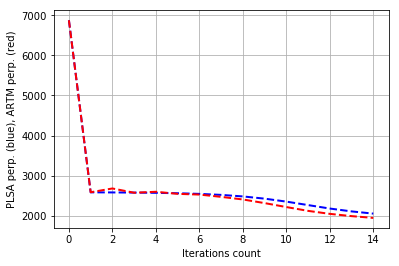

In [27]:
def print_measures(model_plsa, model_artm):
    print 'Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value)

    print 'Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value)

    print 'Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast)

    print 'Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity)

    print 'Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value)

    plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             xrange(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_artm)

Видно, что улучшения разреженностей и ядровых характеристик есть, а ухудшение перплексии невелико. Попробуем увеличить по модулю значения коэффициентов регуляризации при регуляризаторах:

In [28]:
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -0.2
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

Кроме того, подключим к каждой из моделей функционал TopTokensScore, который позволит взглянуть на самые вероятные слова в каждой теме:

In [29]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

Продолжим обучение моделей, инициировав 25 проходов по коллекции, после чего снова посмотрим на значения функционалов качества:

In [30]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

Sparsity Phi: 0.093 (PLSA) vs. 0.841 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.023 (ARTM)
Kernel contrast: 0.640 (PLSA) vs. 0.739 (ARTM)
Kernel purity: 0.674 (PLSA) vs. 0.822 (ARTM)
Perplexity: 1619.035 (PLSA) vs. 1644.216 (ARTM)


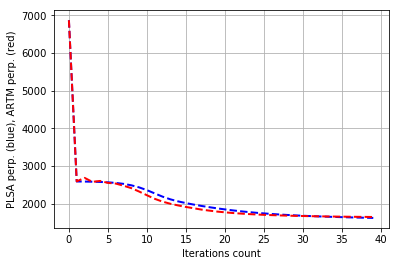

In [31]:
print_measures(model_plsa, model_artm)

Кроме того, для наглядности построим графики изменения разреженностей матриц по итерациям:

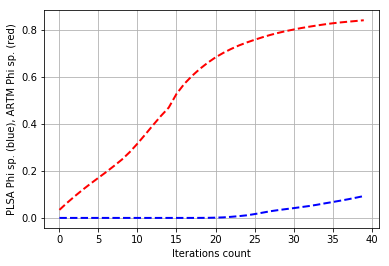

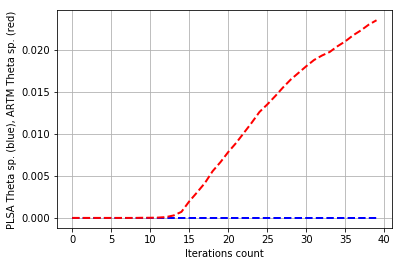

In [32]:
plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

Кажется, что достигнутых результатов достаточно. Регуляризация позволила добиться улучшения всех характеристик, ухудшив перплексию в пределах разумного. Взглянем на топ-слова слова моделей:

In [33]:
for topic_name in model_plsa.topic_names:
    print topic_name + ': ',
    print model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name]

topic_0:  [u'year', u'tax', u'jobs', u'america', u'president', u'issues']
topic_1:  [u'people', u'war', u'service', u'military', u'rights', u'vietnam']
topic_2:  [u'november', u'electoral', u'account', u'polls', u'governor', u'contact']
topic_3:  [u'republican', u'gop', u'senate', u'senator', u'south', u'conservative']
topic_4:  [u'people', u'time', u'country', u'speech', u'talking', u'read']
topic_5:  [u'dean', u'democratic', u'edwards', u'primary', u'kerry', u'clark']
topic_6:  [u'state', u'party', u'race', u'candidates', u'candidate', u'elections']
topic_7:  [u'administration', u'president', u'years', u'bill', u'white', u'cheney']
topic_8:  [u'campaign', u'national', u'media', u'local', u'late', u'union']
topic_9:  [u'house', u'million', u'money', u'republican', u'committee', u'delay']
topic_10:  [u'republicans', u'vote', u'senate', u'election', u'democrats', u'house']
topic_11:  [u'iraq', u'war', u'american', u'iraqi', u'military', u'intelligence']
topic_12:  [u'kerry', u'poll', u'

In [34]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]

topic_0:  [u'party', u'political', u'issue', u'tax', u'america', u'issues']
topic_1:  [u'people', u'military', u'official', u'officials', u'service', u'public']
topic_2:  [u'electoral', u'governor', u'account', u'contact', u'ticket', u'experience']
topic_3:  [u'gop', u'convention', u'senator', u'debate', u'south', u'sen']
topic_4:  [u'country', u'speech', u'bad', u'read', u'end', u'talking']
topic_5:  [u'democratic', u'dean', u'john', u'edwards', u'primary', u'clark']
topic_6:  [u'percent', u'race', u'candidates', u'candidate', u'win', u'nader']
topic_7:  [u'administration', u'years', u'white', u'year', u'bill', u'jobs']
topic_8:  [u'campaign', u'national', u'media', u'press', u'local', u'ads']
topic_9:  [u'house', u'republican', u'million', u'money', u'elections', u'district']
topic_10:  [u'november', u'poll', u'senate', u'republicans', u'vote', u'election']
topic_11:  [u'iraq', u'war', u'american', u'iraqi', u'security', u'united']
topic_12:  [u'bush', u'kerry', u'general', u'preside

Видно, что темы примерно одинаково интерпретируемы, но в модели ARTM они существенно разнообразнее.

Извлечём матрицу $\Phi$ в виде pandas.DataFrame и напечатаем её (в случае необходимости, можно извлекать части матрицы с помощью метода ARTM.get_phi()):

In [36]:
print model_artm.phi_

                   topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
predebate         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
barbour           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
bumblebums        0.000000  0.000000  0.000620  0.000000  0.000000  0.000000   
spindizzy         0.000000  0.000000  0.000647  0.000000  0.000000  0.000000   
mcentee           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
aft               0.000000  0.000000  0.000000  0.000000  0.000000  0.000419   
postdebate        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abrams            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
bulb              0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
deanclark         0.000000  0.000000  0.000000  0.000000  0.000000  0.000348   
amphibians        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
flypaper          0.000000  0.000000  0.

Дополнительно извлечём $\Theta$ в виде pandas.DataFrame и напечатаем её:

In [37]:
theta_matrix = model_artm.get_theta()
print theta_matrix

              3001      3002      3003      3004      3005      3006  \
topic_0   0.076121  0.035934  0.069378  0.136763  0.083616  0.011376   
topic_1   0.095388  0.029030  0.034951  0.043516  0.064788  0.022496   
topic_2   0.004087  0.048284  0.012102  0.006648  0.015708  0.520680   
topic_3   0.057739  0.029823  0.122427  0.085728  0.060413  0.016142   
topic_4   0.122659  0.046273  0.084217  0.077540  0.064804  0.014840   
topic_5   0.025646  0.010737  0.024132  0.051743  0.059580  0.017807   
topic_6   0.044074  0.017331  0.072042  0.042680  0.036825  0.017084   
topic_7   0.061900  0.059854  0.022353  0.029254  0.002857  0.005222   
topic_8   0.049225  0.048494  0.043635  0.095823  0.025636  0.016371   
topic_9   0.070107  0.492084  0.014166  0.131111  0.200206  0.025601   
topic_10  0.056218  0.023523  0.158902  0.092289  0.059759  0.239757   
topic_11  0.158816  0.031754  0.028020  0.024615  0.041939  0.006004   
topic_12  0.054254  0.027387  0.191633  0.078728  0.125391  0.05

In [ ]:
test_batch_vectorizer = artm.BatchVectorizer(data_format='batches', data_path='kos_test', batches=['test_docs.batch'])
test_theta_matrix = model_artm.transform(batch_vectorizer=test_batch_vectorizer)
print test_theta_matrix

Exception in thread Thread-12:
Traceback (most recent call last):
  File "/Users/flaren/anaconda/envs/MyPython2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/flaren/anaconda/envs/MyPython2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/Users/flaren/anaconda/envs/MyPython2/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
  File "/Users/flaren/anaconda/envs/MyPython2/lib/python2.7/site-packages/bigartm-0.9.0-py2.7.egg/artm/master_component.py", line 908, in transform
    theta_matrix_info = self._lib.ArtmRequestTransformMasterModelExternal(self.master_id, args)
  File "/Users/flaren/anaconda/envs/MyPython2/lib/python2.7/site-packages/bigartm-0.9.0-py2.7.egg/artm/wrapper/api.py", line 161, in artm_api_call
    self._check_error(result)
  File "/Users/flaren/anaconda/envs/MyPython2/lib/python2.7/site-packages/bigartm-0.9.0-py2.7.egg/artm/w

<h1 align="center"> Conclusion </h1>

Задача построения тематической модели имеет бесконечно большое множество решений. Это даёт большую свободу действий, и регуляризаторы позволяют использовать её для получения результата, удовлетворяющего сразу нескольким требованиям (разреженность, интерпретируемость, удовлетворительное значение перплексии и т.п.).

Приведённый выше пример является демонстрационным, можно пробовать более гибкие стратегии регуляризации для получения ещё более хорошего результата. По аналогичной схеме можно производить эксперименты с более крупными коллекциями.


** Check questions **

1) В чем основноя отличие PLSA и LDA? На каких объемах выборок разница между моделями наиболее заметна?

2) Зачем нужна регуляризация тематической модели?

3) По каким параметрам можно сделать предположения о интерпретируемости модели?


## References

[1]  Hofmann T. Probabilistic latent semantic indexing. SIGIR 1999. Pp.50-57

[2] Blei D., Ng A., Jordan M. Latent Dirichlet Allocation //
    Journal of Machine Learning Research, 2003. - No.3.  Pp. 993-1022.
